<a href="https://colab.research.google.com/github/MevrouwHelderder/Assignments/blob/main/Assignment_Shark_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment: 
Take [this dataset](https://www.kaggle.com/felipeesc/shark-attack-dataset). Use all the skills you've learned up until now to answer the following questions as well as possible. 

* What are the most dangerous types of sharks to humans? 
* Are children more likely to be attacked by sharks? 
* Are shark attacks where sharks were provoked more or less dangerous? 
* Are certain activities more likely to result in a shark attack? 

If you feel you can't answer a question based on the dataset alone, feel free to find other datasets and use them in answering the questions.

For each answer you give not only answer the question but also write about the assumptions you made in answering the question. If an assumption or decision possibly created a bias please write about this as well.

# The essentials

In [ ]:
# Importing the essentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

%load_ext google.colab.data_table

In [59]:
# importing the dataframe
path = "/content/drive/MyDrive/attacks.csv"
df = pd.read_csv(path, encoding="ISO-8859-1")

In [60]:
# Making a copy so to not change the original dataset while modifying the shape
attacks_shape = df.copy(deep=True)

# Preparing the basics of the dataframe

In [61]:
# Dropping columns.
attacks_shape = attacks_shape.drop(
    columns=[
        "Case Number",
        "Date",
        "Time",
        "Year",
        "Country",
        "Case Number",
        "Location",
        "Name",
        "Investigator or Source",
        "pdf",
        "href formula",
        "Area",
        "href",
        "Sex ",
        "Case Number.1",
        "Case Number.2",
        "original order",
        "Unnamed: 22",
        "Unnamed: 23",
    ]
)

In [62]:
#Checking on the names of the column
list(attacks_shape)

# Renaming columns.
attacks_shape = attacks_shape.rename(
    columns={"Fatal (Y/N)": "Outcome", "Species ": "Species"})

In [63]:
# Dropping rows that have a null value on all columns except for the column "Case".
# Having only a casenumber made them useless by default.
#
# Making a copy to prevent view vs copy issues later on 


relevant_columns = list(attacks_shape.columns[1:])
attacks_shape = attacks_shape.dropna(subset=relevant_columns, how="all").copy(deep=True)


# Helpers
Some broader functions I used during the process

In [65]:
# Function to change values based on a non-nested dictionary
# ⚠️ Mutates df
def replace_multi(df, col, dict):
    df[col] = df[col].replace(dict)
    
# Function to replace a single values with another single value.
# ⚠️ Mutates df
def replace_one(df, col, old_value, new_value):
  df[col] = df[col].replace({old_value : new_value})

# Function to replace multiple values with one value
# ⚠️ Mutates df
def replace_multi_to_one(df, col, old_list, new_value):
  df[col] = df[col].replace(dict.fromkeys(old_list, new_value))

# Function to replace using regular expressions
# ⚠️ Mutates df
def replace_regex(df, col, old_value, new_value):
  df[col] = df[col].str.replace(old_value, new_value, regex=True)


In [66]:
# Function to compare two columns to see how they match in shape:

def compare_columns(df, col_1, col_2):
  col_1_count = df[col_1].notnull().sum()
  col_both_count = (df[col_1].notnull() & df[col_2].notnull()).sum()
  difference = col_1_count - col_both_count
  print (f"The amount of rows with a confirmed value in column {col_1} is: {col_1_count}")
  print (f"The amount of rows with a confirmed value in both column {col_1} and {col_2} is:  {col_both_count}")
  if difference <0:
    print (f"There are {difference} rows where the {col_2} is confirmed but {col_1} is not ")
  elif difference >= 0:
    print (f"There are {difference} rows where the {col_1} is confirmed but {col_2} is not ") 


The functions below are not my own: we used them in an earlier exercise.

However, they are useful and it felt dumb to needlessly change them up to pretend that they were my own.

So credit where credit is due, thanks Winc!

In [64]:
# Functions to help finding non-default missing values:

# Preparing the functions for locating and adjusting the missing values.
def print_separator(sep, num, msg):
    print("\n")
    print(sep * num)
    print(f"{msg}")
    print(sep * num)

# TACTIC A: find unique values
def look_at_unique_values(column):
    unique_values_cutoff = 50
    unique_values = column.unique()
    num_unique_values = len(unique_values)
    if num_unique_values == len(column):
        print(f"Each value in the column is unique (total: {num_unique_values})")
    elif num_unique_values < unique_values_cutoff:
        print(f"Less than {unique_values_cutoff} unique values:")
        try:
            sorted = np.sort(unique_values)
            print("Values are sorted")
            display(list(sorted))
        except:
            print("Could not sort values")
            display(list(unique_values))
    else:
        print(
            f"More than {unique_values_cutoff} unique values (total: {num_unique_values})"
        )

# TACTIC B: look at the edges
def look_at_edges(df, column_name):
    # inner function
    def show_head_and_tail(values):
        num_items_to_slice = 10
        display(list(values)[:num_items_to_slice])
        display(list(values)[-num_items_to_slice:])

    column = df[column_name]
    unique_values = column.unique()
    try:
        sorted = np.sort(unique_values)
        print("Unique values sorted, head and tail:")
        show_head_and_tail(sorted)
    except TypeError as error:
        print(f"Could not sort values: {error}")
        print("..so let's try filtering NULL values and then sorting")
        print("..there could be a black sheep in the null values")
        non_null_uniques = df.loc[~df[column_name].isnull(), column_name].unique()
        sorted = np.sort(non_null_uniques)
        show_head_and_tail(sorted)

# TACTIC C: casting to a type to see if all the values match the needed type
def cast_to_type(column, maybe_type):
    try:
        column.astype(maybe_type)
        print(f"Casting to {maybe_type} was successful")
    except ValueError as error:
        print(f"Could not cast to {maybe_type}: {error}")

# TACTIC D: display the value count of the column
def value_count(column):
    display(column.value_counts(dropna=False))

# FUNCTION TO CHECK THE DATAFRAME FOR ALL FOUR TACTICS
def find_non_default_missing_values(df, column_name, maybe_type):
    long_separator_amount = 80
    short_separator_amount = 40
    # Print the header
    print_separator(
        "*",
        long_separator_amount,
        f'Finding non default missing values for column "{column_name}"',
    )
    print(f'Column "{column_name}" has datatype: {df.dtypes[column_name]}')
    column = df[column_name]
    # A
    print_separator("-", short_separator_amount, "A: Looking at unique values")
    look_at_unique_values(column)
    # B
    print_separator("-", short_separator_amount, "B: Sorting and looking at the edges")
    look_at_edges(df, column_name)
    # C
    print_separator("-", short_separator_amount, f"C: Casting to type: {maybe_type}")
    cast_to_type(column, maybe_type)
    # D
    print_separator(
        "-",
        short_separator_amount,
        "D: Looking at frequency\nAll default-NULL values will be bunched together as NaN",
    )
    value_count(column)
    print("\n")

# Function to display the default NULL values in the column.
def display_default_null_values(df, column_name):
    nulls = df.loc[df[column_name].isnull()]
    print(f'Number of default null values in "{column_name}": {len(nulls)}')

# Easier to type
nat = np.datetime64("nat")

# Cleaning up the columns
Goal: keep only the data needed.

I do apologise beforehand. I suspect on some columns I did more than needed for this assignment, especially when cleaning up/sorting out the last crumbs. 

I realise they probably have no significant influance and that when time and or money are an issue they probably should have been left as they were or even thrown out, depending on the goal.
But I simply had a blast and it tought me so many new skills that I took the opportunity to learn by doing.

I might also have used one tactic on a column but another on a different column. In between working on the different columns I learned a lot and I also experimented to see what worked better.

And lastly: I realise I have written some functions that could perhaps be combined. However, for now I prefer to leave them since they show the steps I took while cleaning up.

In [67]:
# Making a copy to work on, to keep track of the changes
attacks_clean = attacks_shape.copy(deep=True)

In [68]:
# Lowercase all strings and strip whitespace and/or quotationmarks around strings
attacks_clean = attacks_clean.applymap(lambda x: x.lower() if isinstance(x, str) else x)
attacks_clean = attacks_clean.applymap(lambda x: x.strip('" ') if isinstance(x, str) else x)

# Column: Species

In [69]:
# Checking how everything looks and what stands out: 
# find_non_default_missing_values(attacks_clean, 'Species', 'string')

In [70]:
# Extract the species from the string where possible

# if any for of null: change to None
# if empty after stripping whitespace: change to None
# if the word shark is there: return that plus the word before "shark"
# else: return the original plus "check: "

def tidy(x):                                
    if pd.isna(x):                                    
        return None
    elif len(x.strip()) == 0:                         
        return None
    elif "shark" in x:                                
        return re.search(r"(\S+\s*)?shark", x).group()
    else:
        return f"check: {x}"                          


attacks_clean["Species"] = attacks_clean["Species"].apply(tidy)

In [71]:
# Things we can now safely change to "unconfirmed"
# Values that mention certain words.
# Values that mention no species but mention measurements like 20"] 

no_species = [
    "invalid",
    "unidentified",
    "questionable",
    "possibly",
    "not confirmed",
    "unconfirmed",
    "doubtful",
    "captive",
    "unknown",
    "several",
    "colored",
    "large shark",
    "female shark",
    "grey shark",
    "two shark",
    "the shark",
    "from shark",
    "little shark",
    "larger shark",
    "red shark",
    "young shark",
    "for shark",
    "metre shark",
    "juvenile shark",
    "gray shark",
    "finned shark",
    "small shark"
]

# one or more digits followed by ' or " followed by
# zero or more ] followed by shark, whitespaces optional
inches = r'\d+\s*(["\']{1,})\s*\]*\s*shark'

# string containing two or less letters or digits or -
# followed by shark, whitespaces optional
small_string = r"^[a-z0-9-]{0,2}\s*shark$"

# lb or kg or foot followed by zero or more ] followed by shark, whitespaces optional
measurements = r"(kg|lb|foot)\s*\]*\s*shark"


def tidy_more(x):
    if x is not None and (
        any(word in x for word in no_species)
        or re.search(inches, x)
        or re.search(small_string, x)
        or re.search(measurements, x)
    ):
        return "unconfirmed"
    else:
        return x


attacks_clean["Species"] = attacks_clean["Species"].apply(tidy_more)

In [72]:
# removing quotation marks and this weird little fellas that look the same but are different:  
def remove_weirdos(x):
    if x is None:
        return None
    else:
        return re.sub(r'["]+', "", x)

attacks_clean["Species"] = attacks_clean["Species"].apply(remove_weirdos)

In [73]:
# Checking all values that I previously marked as 'check'
mask_species = attacks_clean["Species"].str.contains("check", na=False)
attacks_clean[mask_species]

# Changing to the right species where possible
correct_species = [
    "blue pointer",
    "wobbegong",
    "whaler",
    "hammerhead",
    "porbeagle",
    "whitetip",
    "horn",
]

def correct_checks(x):
    if x is not None and ("check" in x):
        for word in correct_species:
            if word in x:
                return f"{word} shark"
        else:
            return "unconfirmed"
    else:
        return x

attacks_clean["Species"] = attacks_clean["Species"].apply(lambda x: correct_checks(x))


In [74]:
# Checking last crumbs to clean up:
# Replace a few different writings of the same species

replacing = {"seven-gill shark": "sevengill shark",
        "7-gill shark": "sevengill shark",
        "sevengill  shark": "sevengill shark",
        "black-tipped shark": "blacktip shark",
        "blacktip  shark": "blacktip shark",
        "sand shark": "sandshark",
        "zambesi shark": "zambezi shark"}

replace_multi(attacks_clean, "Species", replacing)

In [75]:
# attacks_clean["Species"].value_counts().head(50)
# attacks_clean["Species"].value_counts().tail(50)

In [76]:
# Added later: 
# change everything unconfirmed to None.
# For our questions it makes it cleaner to work with.

replace_one(attacks_clean, "Species", "unconfirmed", None)

# Column: Type

In [77]:
# Checking how everything looks and what stands out: 
# find_non_default_missing_values(attacks_clean, "Type", "string")

In [78]:
# After working on the questions I realised I could safely change some values to None: 
replace_list = ["boating", "boatomg", "boat", "sea disaster", "invalid", "questionable", np.nan ]
replace_multi_to_one(attacks_clean, "Type", replace_list, None)

In [79]:
# attacks_clean["Type"].value_counts().head(50)
# attacks_clean["Type"].value_counts().tail(50)

# Column: Activity

In [80]:
# Checking how everything looks and what stands out: 
# find_non_default_missing_values(attacks_clean, "Activity", "string")

In [81]:
# Replacing the null values
replace_activity = {".": None, np.nan: None}
replace_multi(attacks_clean, "Activity", replace_activity)

# Boarding seems to be a substantial part. Combining different spellings of the same value
boarding = ["boogie boarding", "paddle boarding", "body-boarding", "body boarding", "paddle-boarding"]
replace_multi_to_one(attacks_clean, "Activity", boarding, "bodyboarding")

In [82]:
# Taking the top 60 values as categories and dividing the other values, where possible,
# into those categories.

top_activities = list(attacks_clean["Activity"].value_counts().head(60).index)

def activities_checks(x):
    if x is not None:
      for word in top_activities:
          if word in x:
              return word
      else:
          return x

attacks_clean["Activity"] = attacks_clean["Activity"].apply(lambda x: activities_checks(x))

In [83]:
# attacks_clean["Activity"].value_counts().head(50)
# attacks_clean["Activity"].value_counts().tail(50)

# Column: Outcome

In [84]:
# Checking how everything looks and what stands out: 
# find_non_default_missing_values(attacks_clean, "Outcome", "string")

In [85]:
# Changing values to corresponding categories
replace_outcome = {"n" : "nonfatal", "y" : "fatal", "m" : "unconfirmed", "2017": "unconfirmed", "unknown": "unconfirmed", np.nan : None}
replace_multi(attacks_clean, "Outcome", replace_outcome)

In [86]:
# attacks_clean["Outcome"].value_counts().head(50)
# attacks_clean["Outcome"].value_counts().tail(50)

In [87]:
# Added later: 
# change everything unconfirmed to None.
# For our questions it makes it cleaner to work with.

replace_one(attacks_clean, "Outcome", "unconfirmed", None)

# Column: Age

In [88]:
# Checking how everything looks and what stands out: 
# find_non_default_missing_values(attacks_clean, "Age", "string")

In [89]:
# change NaN to None
replace_age= {np.nan : None, "": None}
replace_multi(attacks_clean, "Age", replace_age)

In [90]:
# convert non-null values to string
non_null = attacks_clean["Age"].notnull()
attacks_clean.loc[non_null, "Age"] = attacks_clean.loc[non_null, "Age"].astype(str)

In [91]:
# Sorting into age groups, creating a new column for this

# Sorting ages by range
child = [str(i) for i in range(0, 13)]
adolescent = [str(i) for i in range(13, 18)]
adult = [str(i) for i in range(18, 130)]

# Sorting all the values that describe the age in words
child_words = ["child", "2 to 3 months", "9 months", "18 months", "2½", "both 11", "6½"]
adolescent_words = ["teen", "teens"]
adult_words = ["adult" , "middle-age", "(adult)", "20s", "30s", "40s", "50s", "elderly", "60's", "60s", "mid-20s", "mid-30s", "ca. 33"]

# tackling values that mention multiple ages by splitting into seperate ages
# and sorting into the right group but only if all ages belong to the same group 
def age_groups(age):
    if age is None:
        return age
    else:
        age_list = re.split(r'[,&\s?]|(?:\s*(?:to|or)\s*)', age) 
        age_list = list(filter(None, age_list))  
        if all(word in child for word in age_list) or age in child_words:
            return "child"
        elif all(word in adolescent for word in age_list) or age in adolescent_words:
            return "adolescent"
        elif all(word in adult for word in age_list) or age in adult_words:
            return "adult"
        else:
            return None

attacks_clean.insert(3, "Age_group", attacks_clean["Age"].apply(age_groups))

In [115]:
# Dropping column age.
attacks_clean = attacks_clean.drop(
    columns=[
        "Age"])

# Column: Injury

I noticed a lot of injuries were the same but with different spellings.
I sorted them into broader groups.

It could have been sorted even more but I found this to be a good medium.

In [116]:
# Checking how everything looks and what stands out: 
# find_non_default_missing_values(attacks_clean, "Injury", "string")

In [117]:
# change NaN to None
replace_injury= {np.nan : None, "": None}
replace_multi(attacks_clean, "Injury", replace_injury)

In [118]:
# Removing some words for better sorting, stripping whitespace
removable = r"\bleft\b|\bright\b|\bminor\b|\bsevere\b|\blower\b|\bto dorsum of\b|\bsmall\b"
replace_regex(attacks_clean, "Injury", removable, "no injury")
# stripping whitespace
attacks_clean["Injury"] = attacks_clean["Injury"].str.strip()

# Correcting some words for better sorting
replace_one(attacks_clean, "Injury", "injury", "injuries")

# Replace values that contain "fatal" with just "fatal"
replace_regex(attacks_clean, "Injury", r".*\bfatal\b.*", "fatal")

# Replace values that contain "no injury" with just "no injury"
replace_regex(attacks_clean, "Injury", r".*\bno injury\b.*", "no injury")

In [119]:
# Combining laceration/lacerated/etc.

# Replace "laceration" with "lacerations"
replace_regex(attacks_clean, "Injury", r"\blaceration\b", "lacerations")
# Replace "lacerated" with "lacerations"
replace_regex(attacks_clean, "Injury", r"\blacerated\b", "lacerations")

# If "lacerations" is present: place it at the front of the string
def move_lacerations_to_front(injury):
    if injury is None:
        return injury
    else: 
      if "lacerations" in injury:
         return "lacerations " + injury.replace("lacerations", "").strip()
      else:
         return injury.strip()

# Apply the function to the "Injury_2" column
attacks_clean["Injury"] = attacks_clean["Injury"].apply(move_lacerations_to_front)

In [120]:
# Combining injured/injury/etc.

# Replace "injuries" with "injury"
replace_regex(attacks_clean, "Injury", r"\binjuries\b", "injury")
# Replace "injured" with "injury to"
replace_regex(attacks_clean, "Injury", r"\binjured\b", "injury to")

# If "injury to" is present: place it at the front of the string
def move_injury_to_front(injury):
    if injury is None:
        return injury
    else: 
      if "injury to" in injury:
         return "injury to " + injury.replace("injury to", "").strip()
      else:
         return injury.strip()

# Apply the function to the "Injury_2" column
attacks_clean["Injury"] = attacks_clean["Injury"].apply(move_injury_to_front)

In [121]:
# Remove double whitespaces
replace_regex(attacks_clean, "Injury", r"\s{2,}", " ")

In [122]:
# Checking how it looks now: 
# attacks_clean["Injury"].value_counts().head(20)
# attacks_clean["Injury"].value_counts().tail(20)

# On to the questions!


In [123]:
# Making a copy to prevent messing up earlier steps: 
shark_attacks = attacks_clean.copy(deep=True)

# Question 1: What are the most dangerous types of sharks to humans?
**Thoughts**: You could think it is as simply the species that has the highest count of attacks.

**But**: what is the definition of "most dangerous"? 

Is a species that has a lot of non-fatal attacks more dangerous than a species that attacks less but whos attacks are often fatal?

Let's look at the outcome of the attacks. 
Is there a correlation betweet the species that attack the most and the species that have the most fatal attacks?


---





Before I do that I need to know if the groups of results where both the species AND the outcome is confirmed is big enough. 
To do that I will compare that group to the group where only the species is confirmed.

In [124]:
compare_columns(shark_attacks, "Species", "Outcome")

The amount of rows with a confirmed value in column Species is: 1914
The amount of rows with a confirmed value in both column Species and Outcome is:  1887
There are 27 rows where the Species is confirmed but Outcome is not 


That is a really small difference.
I feel confident that for this question I can work with only the attacks where both the species and the outcome are confirmed. 


---



# Visualising the attacks per species
I want to not only show amount of attacks per species but also the percentage of the attacks that is fatal.

However, there is no use to look at the fatality rate alone. A species that has only one record would get a 100% rate, for example. 

Therefore, I will use it together with the total attack count of the species that are in the top ten of species that have the most attacks on their names.

In [125]:
# Selecting only the rows where both species and outcome are confirmed: 
question_one_mask = (shark_attacks["Species"].notnull()) & (shark_attacks["Outcome"].notnull())
question_one_df = shark_attacks[question_one_mask]

In [126]:
# Top ten species when looking at total attacks
total_species = question_one_df["Species"].value_counts()
top_total_species = total_species.sort_values(ascending=False).head(10)

# Fatal attack count per species.
fatal_species = question_one_df.loc[question_one_df["Outcome"] == "fatal", "Species"].value_counts()

# Fatality rate for each species.
fatality_species = (fatal_species / total_species) * 100

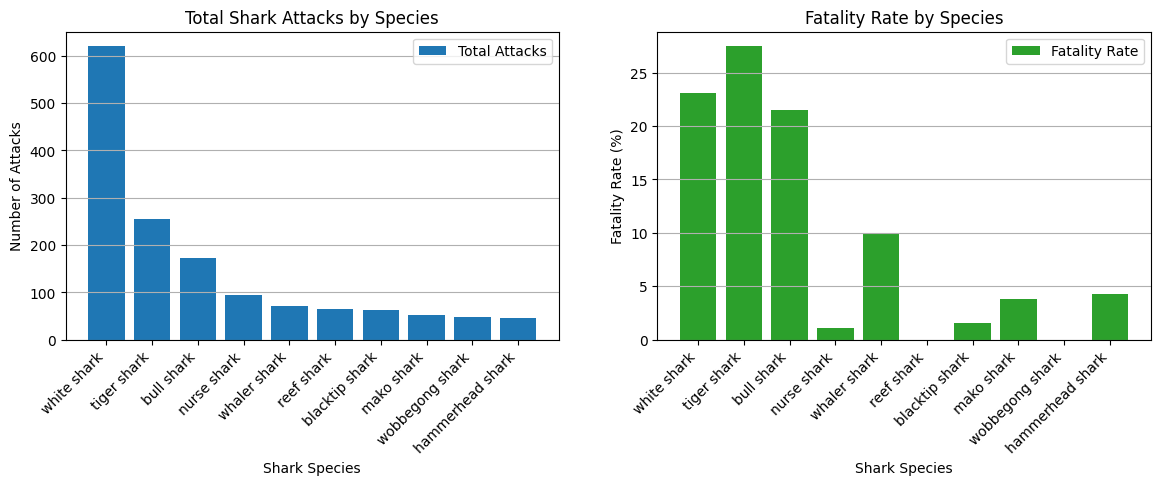

In [127]:
# Create the figure and the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# X-axis both plots
species = top_total_species.index

# Y-axis total attacks
total_bar = top_total_species
# Y-axis fatality rate
fatality_bar = fatality_species.loc[top_total_species.index] 

# Bars
ax1.bar(species, total_bar, label="Total Attacks")
ax2.bar(species, fatality_bar, label="Fatality Rate", color="C2")

# Set common cosmetics
for ax in [ax1, ax2]:
    ax.set_xlabel("Shark Species")
    ax.set_xticks(species)
    ax.set_xticklabels(species, rotation=45, ha="right")
    ax.grid(axis="y")
    ax.legend()
    
# Set individual cosmetics
ax1.set_ylabel("Number of Attacks")
ax1.set_title("Total Shark Attacks by Species")
ax2.set_ylabel("Fatality Rate (%)")
ax2.set_title("Fatality Rate by Species")
plt.subplots_adjust(wspace=0.2)

plt.show()

# Conclusion: Interesting!

We can see that the white shark is responsible for the most attacks in general and the most attacks with a deadly outcome. Almost twice as much in both categories than the species that comes second: the tiger shark.
That is why I deem the white shark the species that is most dangerous to humans. 

However: we can see that the tiger shark has the highest fatality rate. Higher than the white shark. In other words: it attacks less but its attacks are more dangerous then the attacks of the white shark.

So when it comes to answering the question "What are the most dangerous types of sharks to humans?" my answer is:


The white shark. But if for some reason you are faced with two pools, one containing a white shark and one containing a tiger shark and you are forced to jump into one... You might want to consider joining the white shark and not the tiger shark ;-)


---





# Question 2: Are children more likely to be attacked by sharks?

For this I want to look at how the attacks are divided over the age groups.
I have the following groups: adults, children, teens. 

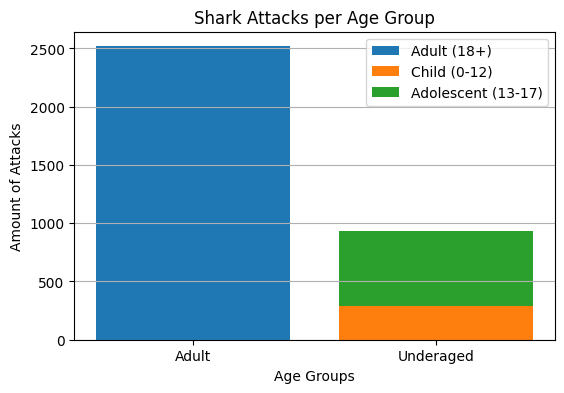

In [128]:
# Create the figure and the plots
fig, ax = plt.subplots(figsize=(6.2, 4))

# Y-axis
age_group = shark_attacks["Age_group"].value_counts()
adult_count = age_group["adult"]
adolescent_count = age_group["adolescent"]
child_count = age_group["child"]

# Bars where the bar for adolescent_count is placed on top on child_count
ax.bar(0, adult_count, label="Adult (18+)")
ax.bar(1, child_count, label="Child (0-12)")
ax.bar(1, adolescent_count, bottom=child_count, label="Adolescent (13-17)")

# Set cosmetics
ax.set_xticks([0, 1])
ax.set_xticklabels(["Adult", "Underaged"])
ax.set_xlabel("Age Groups")
ax.set_ylabel("Amount of Attacks")
ax.set_title("Shark Attacks per Age Group")
ax.legend()
ax.grid(axis="y")

# Show the plot
plt.show()

# Conclusion: 
No, children are not more likely to be attacked by sharks. 
Even when you combine all people under 18 into one group they are still being attacked way less then adults.

Teenagers are more likely to be attacked by a sharks then children under 13 years old.


---




# Question 3: Are shark attacks where sharks were provoked more or less dangerous?

It is not enough to just look at the absolute counts.
Because since there are more unprovoked than provoked attacks it would not be surprising that there are more fatal outcomes for unprovoked attackss than for provoked attacks.
Therefore it is better to look at the proportions. Or, just as with the shark species: the fatality rate.
What percentage of provoked attacks was fatal and what percentage of unprovoked attacks was fatal?


---



First: compare to see if I can use the group where both the outcome and the type is confirmed

In [129]:
compare_columns(shark_attacks, "Type", "Outcome")

The amount of rows with a confirmed value in column Type is: 5169
The amount of rows with a confirmed value in both column Type and Outcome is:  5099
There are 70 rows where the Type is confirmed but Outcome is not 


I feel confident I can use these two groups together.


---



In [130]:
# Selecting only the rows where both type and outcome are confirmed: 
question_three_mask = (shark_attacks["Type"].notnull()) & (shark_attacks["Outcome"].notnull())
question_three_df = shark_attacks[question_three_mask]

In [108]:
# Attack count per type.
total_type = question_three_df["Type"].value_counts()

# Fatal attacks for each type.
fatal_type = question_three_df.loc[question_three_df["Outcome"] == "fatal", "Type"].value_counts()

# Fatality rate per type.
fatality_type = (fatal_type/total_type) * 100

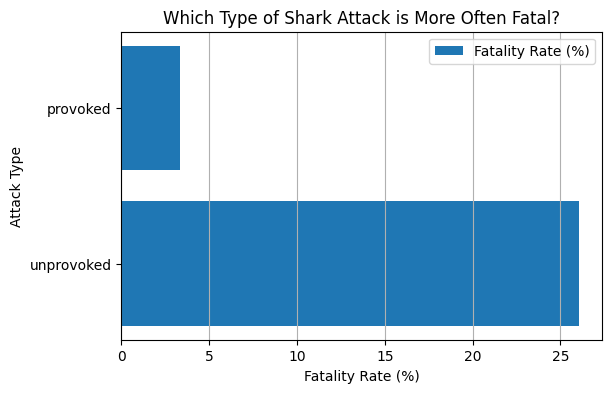

In [135]:
# Create the figure and the plots
fig, ax = plt.subplots(figsize=(6.2, 4))

# Bars
ax.barh(fatality_type.index, fatality_type, label="Fatality Rate (%)")

# Set cosmetics
ax.set_xlabel("Fatality Rate (%)")
ax.set_ylabel("Attack Type")
ax.set_title("Which Type of Shark Attack is More Often Fatal?")
ax.legend()
ax.grid(axis= "x")

# Show the plot
plt.show()

# Conclusion: 

A bit more than 25% of unprovoked attacks had a fatal outcome.
3% Of the provoked attacks had a fatal outcome.

That means that an unprovoked attack could be seen as more dangerous than a provoked attack.

I first was surprised by this since my first thought was that most sharks are not that agressive at all.
However, one could argue that a provoked attack has more often the purpose of defence, where an unprovoked attack has a higher chance of having a purpose of offence.

# Question 4: Are certain activities more likely to result in a shark attack?

Even though it is not the question I am also curious about the fatality of the different activities.
I will compare them first to see if it is any use looking at them together.

In [110]:
compare_columns(shark_attacks, "Activity", "Outcome")

The amount of rows with a confirmed value in column Activity is: 5755
The amount of rows with a confirmed value in both column Activity and Outcome is:  5305
There are 450 rows where the Activity is confirmed but Outcome is not 


That is a bit of a bigger difference than I like. 
But what I can do to check further is see what happens when I only look at the top ten activities, since that is what I am working with anyway.

In [111]:
# Top ten activities when looking at total attacks
total_activities = shark_attacks["Activity"].value_counts()
top_activities = total_activities.sort_values(ascending=False).head(10)

# Put those in a list so I can select only the rows with those values 
top_act_list = top_activities.index.tolist()

filtered_df = shark_attacks[shark_attacks["Activity"].isin(top_act_list)]

In [113]:
compare_columns(filtered_df, "Activity", "Outcome")

The amount of rows with a confirmed value in column Activity is: 4717
The amount of rows with a confirmed value in both column Activity and Outcome is:  4367
There are 350 rows where the Activity is confirmed but Outcome is not 


Not much better... Since the original question is not about the fatality I will 
answer that question first using the whole dataframe. 

And then I will check about the fatality for funsies using the rows where both columns have confirmed values. It would make the dataset a bit smaller but still not completely useless.
Just to satify my curiousity!

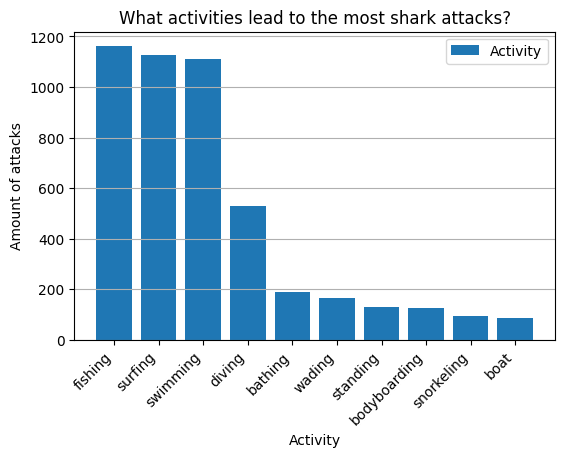

In [138]:
# Create the figure and the plots
fig, ax = plt.subplots(figsize=(6.2, 4))

# Bars
ax.bar(top_activities.index, top_activities, label="Activity")

# Set cosmetics
ax.set_xlabel("Activity")
ax.set_ylabel("Amount of attacks")
ax.set_title("What activities lead to the most shark attacks?")
ax.legend()
ax.grid(axis= "y")
ax.set_xticks(top_activities.index)
ax.set_xticklabels(top_activities.index, rotation=45, ha="right")

# Show the plot
plt.show()